# Assessing network performance

**Author:** Amanda M. Thomas  
**Goal:** This notebook computes some performance metrics commonly used to assess network performance.

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time
import seisbench.data as sbd
from torch.utils.data import random_split, DataLoader
import seisbench.generate as sbg
import pandas as pd
from scipy.signal import find_peaks

## 1. Load the U-Net Architecture

We need to first load in the network architecture.

In [2]:
# Cell 2: U-Net Building Blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[16, 32, 64, 128]):
        super().__init__()
        
        self.downs = nn.ModuleList()  # Encoder blocks (downsampling path)
        self.ups = nn.ModuleList()    # Decoder blocks (upsampling path)
    
        # ----- Encoder: Downsampling Path -----
        # Each ConvBlock halves the temporal resolution via pooling (done in forward),
        # and increases the number of feature channels.
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))  # ConvBlock: Conv + ReLU + Conv + ReLU
            in_channels = feat  # Update in_channels for the next block
    
        # ----- Bottleneck -----
        # Deepest layer in the U-Net, connects encoder and decoder
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)
    
        # ----- Decoder: Upsampling Path -----
        # Reverse features list for symmetrical decoder
        rev_feats = features[::-1]
        for feat in rev_feats:
            # First upsample (via transposed convolution)
            self.ups.append(
                nn.ConvTranspose1d(feat*2, feat, kernel_size=2, stride=2)
            )
            # Then apply ConvBlock: input has double channels due to skip connection
            self.ups.append(ConvBlock(feat*2, feat))
    
        # ----- Final Output Convolution -----
        # 1x1 convolution to map to desired output channels (e.g., P, S, noise)
        self.final_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool1d(x, kernel_size=2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_conn = skip_connections[idx//2]
            if x.shape[-1] != skip_conn.shape[-1]:
                x = F.pad(x, (0, skip_conn.shape[-1] - x.shape[-1]))
            x = torch.cat((skip_conn, x), dim=1)
            x = self.ups[idx+1](x)
        x = self.final_conv(x)
        return F.softmax(x, dim=1)

We then intialize the model and load in the model weights.

In [3]:
model = UNet1D()

# This cell loads the saved weights into the model.
model.load_state_dict(torch.load("../Loic/UNet/model_weights_eq_only.pt",weights_only=True, map_location=torch.device('cpu')))
model.eval() 

UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (1): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (2): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
      )
    )
    (3): ConvBlock(
      (conv): Sequential(
        (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU

# 2. Load the dataset from the current directory

Loads the "meso" PNW dataset.

In [4]:
data = sbd.WaveformDataset("../data/waveform_dataset/")
print(data.metadata["source_type"].value_counts())
data._metadata = data.metadata[data.metadata.source_type == "earthquake"].reset_index(drop=True)
data.metadata
print(data.metadata["source_type"].value_counts())

2025-05-05 16:19:52,325 | seisbench | WARNING | Dimension order not specified in data set. Assuming CW.
2025-05-05 16:19:52,331 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
2025-05-05 16:19:52,331 | seisbench | WARNING | Default output component order 'ZNE' does not match dataset component order 'ENZ'. Please make sure this is intended.


source_type
earthquake    17960
explosion       680
Name: count, dtype: int64
source_type
earthquake    17960
Name: count, dtype: int64


Define the test dataset and the labels.

In [5]:
test = data.test()

phase_dict = {"trace_P_arrival_sample": "P",
              "trace_S_arrival_sample": "S"}

model_labels = ["P", "S", "noise"]

# 3. Set up and test the generator

Set up generator.

In [6]:
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(
        list(phase_dict.keys()), samples_before=3000, windowlen=6000,
        selection="random", strategy="variable"
    ),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, model_labels=model_labels, sigma=30, dim=0)
]

test_generator.add_augmentations(augmentations)

Plot generator output.

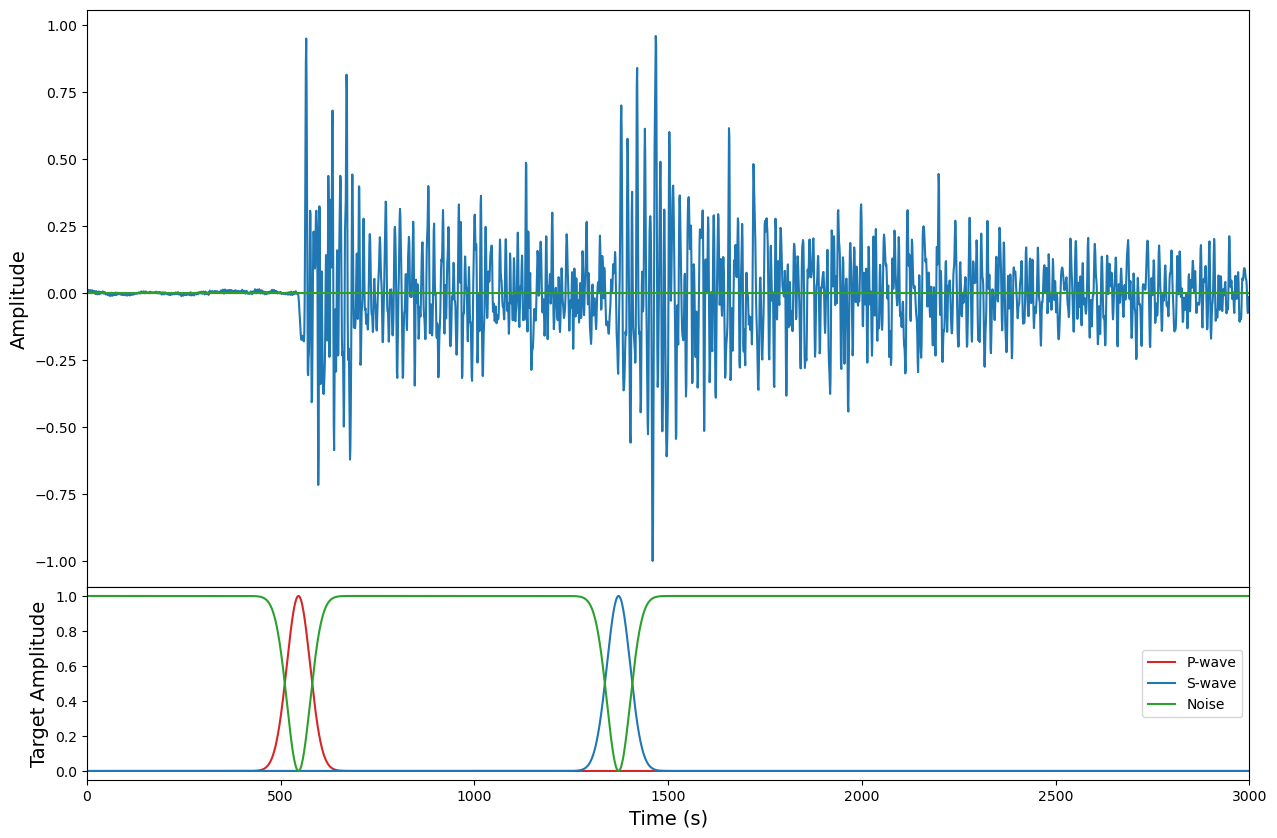

In [7]:
sample_id = 5
sample = test_generator[sample_id]
# Plot timeseries
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"][0].T,label='P-wave',color="tab:red")
axs[1].plot(sample["y"][1].T,label='S-wave',color="tab:blue")
axs[1].plot(sample["y"][2].T,label='Noise',color="tab:green")
axs[1].set_xlabel('Time (s)',fontsize=14)
axs[1].set_ylabel('Target Amplitude',fontsize=14)
axs[0].set_ylabel('Amplitude',fontsize=14)
axs[1].set_xlim((0,3000))
plt.legend()

# 4. Make test predictions

Next we make predictions on the test set.

,p_idx_max,p_pred_idx_max,p_pred_val,s_idx_max,s_pred_idx_max,s_pred_val
0,1334,"[1339, 1505, 2358]","[0.7664831, 0.06997471, 0.0826026]",2354,"[2351, 2494]","[0.40280896, 0.34779605]"
1,635,"[658, 935]","[0.16178893, 0.060194295]",1559,"[657, 1556, 1662, 2881]","[0.056079622, 0.85178494, 0.07732598, 0.1350524]"
2,1110,"[1109, 2693]","[0.98152083, 0.22190376]",2809,[2838],[0.5375835]
3,2146,[2145],[0.9895287],2776,"[2772, 2876]","[0.8637936, 0.18605049]"
4,1424,"[1421, 1789]","[0.9913713, 0.15583223]",1930,[1939],[0.9773741]
...,...,...,...,...,...,...
8965,2178,"[2172, 2385]","[0.9570767, 0.088978335]",2996,"[2360, 2934]","[0.68417394, 0.5286227]"
8966,2994,"[171, 1666, 2605, 2990]","[0.08973603, 0.63563055, 0.09431454, 0.7618094]",[],"[849, 2999]","[0.05290782, 0.13611229]"
8967,[],[],[],60,"[67, 302]","[0.98441523, 0.051905893]"
8968,1377,[1374],[0.9868961],2306,[2303],[0.9681437]


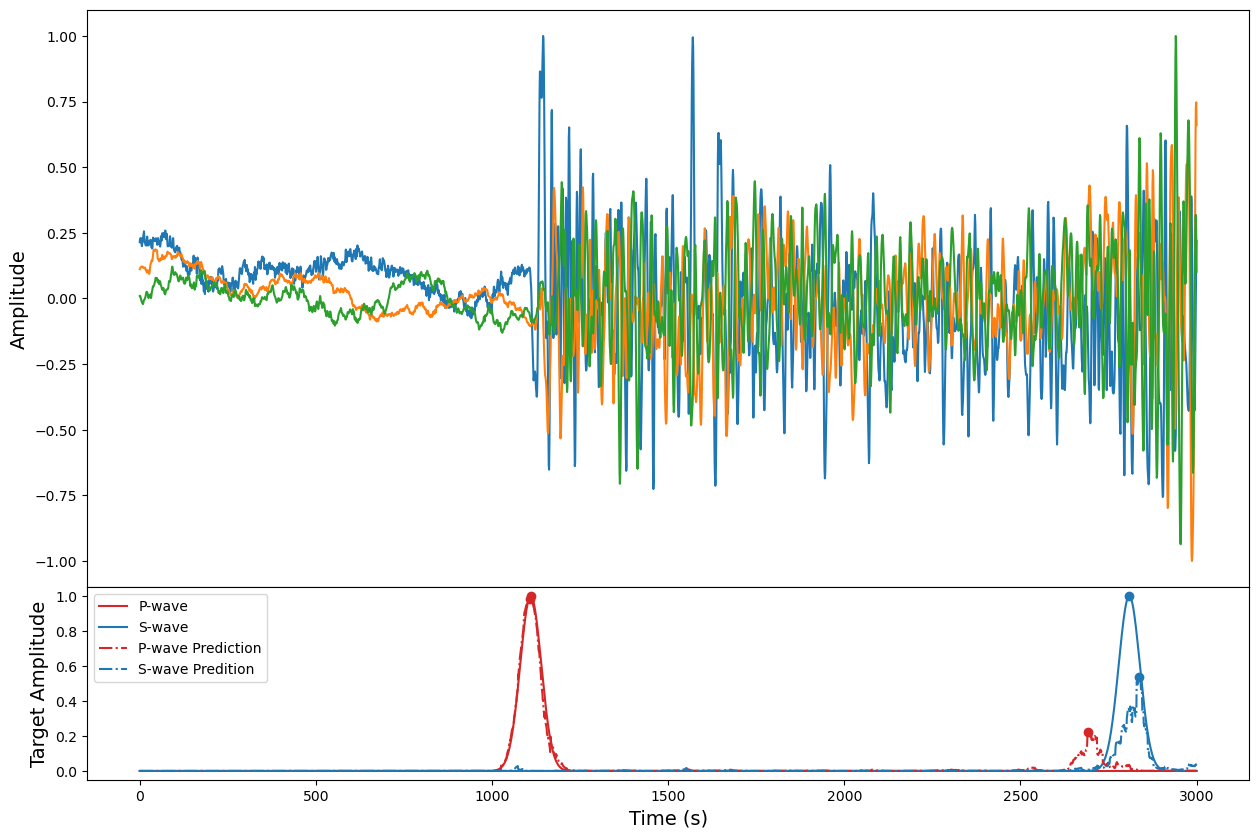

In [8]:
# Define a lambda that returns the index of where the timeseries=1
def idx_max(ts):
    indices = np.where(ts == 1)[0]
    return indices[0] if len(indices) > 0 else []

# Define minimumheight for peak detection
height = 0.05

# Generate augmented samples and log their stats
results =[]
for ii in range(len(test)):
    sample = test_generator[ii]
    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=torch.device('cpu')).unsqueeze(0))  # Add a fake batch dimension
        p_pred, s_pred, noise_pred = pred[0].cpu().numpy()
    
    p_idx_max = idx_max(sample["y"][0])
    s_idx_max = idx_max(sample["y"][1])
    p_pred_idx_max, _ = find_peaks(p_pred, height=height, distance=100) 
    s_pred_idx_max, _ = find_peaks(s_pred, height=height, distance=100) 

    results.append({"p_idx_max": np.array(p_idx_max),
                    "p_pred_idx_max": np.array(p_pred_idx_max), 
                    "p_pred_val": np.array(p_pred[p_pred_idx_max]),
                    "s_idx_max": np.array(s_idx_max),  
                    "s_pred_idx_max": np.array(s_pred_idx_max),
                    "s_pred_val": np.array(s_pred[s_pred_idx_max])})

    # plot some example
    if ii==2:

        # Plot waveforms
        fig = plt.figure(figsize=(15, 10))
        axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
        axs[0].plot(sample["X"].T)

        # Plot target timeseries
        axs[1].plot(sample["y"][0].T,label='P-wave', color="tab:red")
        axs[1].plot(p_idx_max, sample["y"][0][p_idx_max], 'o', color="tab:red")
        axs[1].plot(sample["y"][1].T,label='S-wave', color='tab:blue')
        axs[1].plot(s_idx_max, sample["y"][1][s_idx_max], 'o', color='tab:blue')

        # Plot prediction timeseries
        axs[1].plot(p_pred,label='P-wave Prediction', color="tab:red", linestyle='-.')
        axs[1].plot(p_pred_idx_max,p_pred[p_pred_idx_max], 'o', color="tab:red")
        axs[1].plot(s_pred,label='S-wave Predition', color='tab:blue', linestyle='-.')
        axs[1].plot(s_pred_idx_max,s_pred[s_pred_idx_max], 'o', color="tab:blue")
        axs[1].set_xlabel('Time (s)',fontsize=14)
        axs[1].set_ylabel('Target Amplitude',fontsize=14)
        axs[0].set_ylabel('Amplitude',fontsize=14)
        # axs[1].plot(noise_pred,label='Noise Prediction', color="tab:green", linestyle='-.')
        plt.legend()
        plots=False

results = pd.DataFrame(results)
results

# 5.  Common Performance Metrics

## The Confusion Matrix

The confusion matrix is a tool used to evaluate the performance of a model. It provides insight into the model's performance, errors, and weaknesses which will allow us to further improve our model through fine-tuning.

<img src="./confusion_matrix.png" width="800">

The four categories in the confusion matrix are:

- **True positive (TP)** - The model correctly (true) predicts the positive class (positive).
- **False positive (FP)** - The model incorrectly (false) predicts the positive class (positive).
- **False negative (FN)** - The model incorrectly (false) predicts the negative class (negative).
- **True negative (TN)** - The model correctly (true) predicts the negative class (negative).

Using these categories, there are multiple different metrics one can use to assess network perfomance.  For demonstration purposes, lets say we have a dataset of 100 seismograms.  5 of them contain earthquakes, and 95 of them contain noise.  Lets also say of the 5 earthquakes, the model correctly predicts 4 of them and misses 1.  For the 95 noise samples, the model correctly predicts 90 of them as noise and the other 5 it calls earthquakes.  In this scenario, TP = 4, TN = 90, FP = 5, FN = 1.

## Accuracy

Accuracy shows how often a model is correct overall.  It is defined as the total number of true predictions (i.e. TP + TN) divided by the total number of predictions.

<img src="./accuracy.png" width="600">

In our example above, TP + TN = 94 and the total number of predictions is 100 so we have 94% accuracy overall -- woo hoo!

Accuracy is widely used but its not always useful because it treats all classes as equally important. If a dataset is well balanced, meaning it has equal or nearly equal representation in the training data of all classes, accuracy can be a helpful metric. However, many real-world applications have a high imbalance of classes. These are the cases when one category has significantly more frequent occurrences than the other. In seismology, this would happen if you were to just estimate whether each section of a seismogram had an earthquake or recorded only noise. In scenarios like this, you are typically interested in predicting the events that rarely occur (i.e. earthquakes). It is easy to “game” the accuracy metric when making predictions for a dataset like this. To do that, you simply need to predict that every waveform is noise.  If only 5 in 100 waveforms actually contain an earthquake, a model predicting noise all the time will mostly be right, leading to very high accuracy.  In this particular situaion, your model would be 95% accurate however you'd miss every earthquake -- so high accuracy models can be useless. Overall accuracy is informative but using this metric alone is not advisable.

## Precision

Precision is a metric that measures how often a machine learning model is correct when it predicts the positive class (in our case, earthquakes). You can calculate precision by dividing the number of true positive predictions (TPs) by the total number of instances the model predicted as positive (TP + FP).

<img src="./precision.png" width="600">

In our example above, TP = 4 and FP = 5 so the precition is 4/9 or 44%.  

Precision works well for problems with imbalanced classes since it shows the model correctness in identifying the positive class.  It's important to note that precision does not consider false negatives meaning it does not account for the cases when we miss earthquakes.   

## Recall

Recall is a metric that measures how often a machine learning model correctly identifies positive instances (TP) from all the actual positive samples in the dataset (TP + FN). 

<img src="./recall.png" width="600">

From our example above, TP = 4 and FN = 1, so our recall is 4/5 or 80%.

Recall works well for problems with imbalanced classes since it is focused on the model’s ability to find earthquakes.  Recall is useful when the cost of false negatives is high. In this case, you typically want to find all earthquakes, even if this results in some false positives (predicting an earthquake when it is actually noise).  A downside is that recall does not account for the cost of these false positives.

# 6. Compute UNet Performance metrics

Looking back at the original Zhu and Beroza [2019] paper that introduced PhaseNet, they have a little bit of a problem.  They've set up the earthquake detection problem as a regression where the network outputs a "probability" between 0 and 1 to identify noise (0) vs. a phase arrival (1).  So how do we translate this into a classicifcation problem so that we can use the swanky metrics we introduced above?  Well they did it as follows (and so will we!):

- **True positive** - peak amplitude is above decision threshold and < 0.1s from true arrival
- **False positive** - peak amplitude is above decision threshold and >= 0.1s from true arrival
- **False negative** - peak amplitude is below decision threshold and < 0.1s from true arrival
- **True negative** - peak amplitude is below decision threshold and >= 0.1s

In [9]:
results

,p_idx_max,p_pred_idx_max,p_pred_val,s_idx_max,s_pred_idx_max,s_pred_val
0,1334,"[1339, 1505, 2358]","[0.7664831, 0.06997471, 0.0826026]",2354,"[2351, 2494]","[0.40280896, 0.34779605]"
1,635,"[658, 935]","[0.16178893, 0.060194295]",1559,"[657, 1556, 1662, 2881]","[0.056079622, 0.85178494, 0.07732598, 0.1350524]"
2,1110,"[1109, 2693]","[0.98152083, 0.22190376]",2809,[2838],[0.5375835]
3,2146,[2145],[0.9895287],2776,"[2772, 2876]","[0.8637936, 0.18605049]"
4,1424,"[1421, 1789]","[0.9913713, 0.15583223]",1930,[1939],[0.9773741]
...,...,...,...,...,...,...
8965,2178,"[2172, 2385]","[0.9570767, 0.088978335]",2996,"[2360, 2934]","[0.68417394, 0.5286227]"
8966,2994,"[171, 1666, 2605, 2990]","[0.08973603, 0.63563055, 0.09431454, 0.7618094]",[],"[849, 2999]","[0.05290782, 0.13611229]"
8967,[],[],[],60,"[67, 302]","[0.98441523, 0.051905893]"
8968,1377,[1374],[0.9868961],2306,[2303],[0.9681437]


In [10]:
# P/S results

# Compute P precision, recall and accuracy
decision_thresholds=np.arange(0.05,1,0.05)
pprecision = np.zeros(len(decision_thresholds))
paccuracy = np.zeros(len(decision_thresholds))
precall = np.zeros(len(decision_thresholds))
sprecision = np.zeros(len(decision_thresholds))
saccuracy = np.zeros(len(decision_thresholds))
srecall = np.zeros(len(decision_thresholds))

# P results
for dd, decision_threshold in enumerate(decision_thresholds):
    p_predictions=[]
    p_real=[]
    s_predictions=[]
    s_real=[]

    for _, row in results.iterrows():
        # if there is a P arrival and you predicted one or more P arrivals
        if np.size(row["p_idx_max"]) > 0 and np.size(row["p_pred_idx_max"]) > 0:
            for jj in range(len(row["p_pred_idx_max"])):
                p_real.append(1)
                # if the predicted value is above the decision threshold
                if row["p_pred_val"][jj] > decision_threshold and np.abs(row["p_pred_idx_max"][jj] - row["p_idx_max"]) < 10:
                    p_predictions.append(1)
                else:
                    p_predictions.append(0)
        # if there is a P arrival and you did not predict a P arrival
        elif np.size(row["p_idx_max"]) > 0 and np.size(row["p_pred_idx_max"]) == 0:
            p_real.append(1)
            p_predictions.append(0)
        # if there is NOT a P arrival and and you predicted one or more P arrivals
        elif np.size(row["p_idx_max"]) == 0 and np.size(row["p_pred_idx_max"]) > 0:
            for jj in range(len(row["p_pred_idx_max"])):
                p_real.append(0)
                # if the predicted value is above the decision threshold
                if row["p_pred_val"][jj] > decision_threshold:
                    p_predictions.append(1)
                else:
                    p_predictions.append(0)
        else:
            p_real.append(0)
            p_predictions.append(0)

        # if there is a S arrival and you predicted one or more S arrivals
        if np.size(row["s_idx_max"]) > 0 and np.size(row["s_pred_idx_max"]) > 0:
            for jj in range(len(row["s_pred_idx_max"])):
                s_real.append(1)
                # if the predicted value is above the decision threshold
                if row["s_pred_val"][jj] > decision_threshold and np.abs(row["s_pred_idx_max"][jj] - row["s_idx_max"]) < 10:
                    s_predictions.append(1)
                else:
                    s_predictions.append(0)
        # if there is a S arrival and you did not predict a S arrival
        elif np.size(row["s_idx_max"]) > 0 and np.size(row["s_pred_idx_max"]) == 0:
            s_real.append(1)
            s_predictions.append(0)
        # if there is NOT a P arrival and and you predicted one or more P arrivals
        elif np.size(row["s_idx_max"]) == 0 and np.size(row["s_pred_idx_max"]) > 0:
            for jj in range(len(row["s_pred_idx_max"])):
                s_real.append(0)
                # if the predicted value is above the decision threshold
                if row["s_pred_val"][jj] > decision_threshold:
                    s_predictions.append(1)
                else:
                    s_predictions.append(0)
        else:
            s_real.append(0)
            s_predictions.append(0)

    # Convert lists to numpy arrays
    p_predictions = np.array(p_predictions)
    p_real = np.array(p_real)
    total_p_pred = len(p_predictions)
    print(total_p_pred)

    # Compute confusion matrix components
    TP = np.sum((p_predictions == 1) & (p_real == 1))
    FP = np.sum((p_predictions == 1) & (p_real == 0))
    TN = np.sum((p_predictions == 0) & (p_real == 0))
    FN = np.sum((p_predictions == 0) & (p_real == 1))

    # Compute precision, recall and accuracy
    pprecision[dd]=TP/(TP+FP)
    precall[dd]=TP/(TP+FN)
    paccuracy[dd]=(TP+TN)/total_p_pred

    # Convert lists to numpy arrays
    s_predictions = np.array(s_predictions)
    s_real = np.array(s_real)
    total_s_pred = len(s_predictions)
    print(total_s_pred)

    # Compute confusion matrix components
    TP = np.sum((s_predictions == 1) & (s_real == 1))
    FP = np.sum((s_predictions == 1) & (s_real == 0))
    TN = np.sum((s_predictions == 0) & (s_real == 0))
    FN = np.sum((s_predictions == 0) & (s_real == 1))

    # Compute precision, recall and accuracy
    sprecision[dd]=TP/(TP+FP)
    srecall[dd]=TP/(TP+FN)
    saccuracy[dd]=(TP+TN)/total_s_pred


15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722
15900
12722


In [11]:
len(p_predictions)

15900

# P/S results

# Compute P precision, recall and accuracy
decision_thresholds=np.arange(0.05,1,0.05)
pprecision = np.zeros(len(decision_thresholds))
paccuracy = np.zeros(len(decision_thresholds))
precall = np.zeros(len(decision_thresholds))
sprecision = np.zeros(len(decision_thresholds))
saccuracy = np.zeros(len(decision_thresholds))
srecall = np.zeros(len(decision_thresholds))

# P results
for dd, decision_threshold in enumerate(decision_thresholds):
    cc=0
    p_predictions=[]
    p_real=[]
    s_predictions=[]
    s_real=[]
    # Loop through each window
    for ii in range(len(results)): # for each window
        # P wave
        if is_empty_list(results.iloc[ii]['p_idx_max']) and not is_empty_list(results.iloc[ii]['p_pred_idx_max']): # if there is no P wave in the window, and you DO predict one
            for jj in range(len(results["p_pred_idx_max"][ii])): # loop throught the predicted P waves
                p_real.append(0) # its not a real P wave
                if results["p_pred_val"][ii][jj] > decision_threshold:
                    p_predictions.append(1) # if you predict its above the decision threshold, its a prediction
                else:
                    p_predictions.append(0) # if you predict its below the decision threshold, its not a prediction
        elif not is_empty_list(results.iloc[ii]['p_idx_max']) and is_empty_list(results.iloc[ii]['p_pred_idx_max']): # if there is a P wave in the window, and you dont predict one
            p_real.append(1)
            p_predictions.append(0)
        elif not is_empty_list(results.iloc[ii]['p_idx_max']) and not is_empty_list(results.iloc[ii]['p_pred_idx_max']): # if there is a P wave in the window, and you DO predict one
            for jj in range(len(results["p_pred_idx_max"][ii])):
                p_real.append(1) # it is a real P wave
                if results["p_pred_val"][ii][jj] > decision_threshold and np.abs(results["p_pred_idx_max"][ii][jj]-results['p_idx_max'][ii]) < 10: # if the predicted value is above the decision threshold
                    p_predictions.append(1)
                else:
                    p_predictions.append(0)
        else: # if there is no P wave in the window, and you dont predict one
            p_real.append(0)
            p_predictions.append(0)

        # S wave
        if is_empty_list(results.iloc[ii]['s_idx_max']) and not is_empty_list(results.iloc[ii]['s_pred_idx_max']): # if there is no P wave in the window, and you DO predict one
            for jj in range(len(results["s_pred_idx_max"][ii])):
                s_real.append(0)
                if results["s_pred_val"][ii][jj] > decision_threshold:
                    s_predictions.append(1)
                else:
                    s_predictions.append(0)
        elif not is_empty_list(results.iloc[ii]['s_idx_max']) and is_empty_list(results.iloc[ii]['s_pred_idx_max']): # if there is a P wave in the window, and you dont predict one
            s_real.append(1)
            s_predictions.append(0)
        elif not is_empty_list(results.iloc[ii]['s_idx_max']) and not is_empty_list(results.iloc[ii]['s_pred_idx_max']): # if there is a P wave in the window, and you DO predict one
            for jj in range(len(results["s_pred_idx_max"][ii])):
                s_real.append(1)
                if results["s_pred_val"][ii][jj] > decision_threshold and np.abs(results["s_pred_idx_max"][ii][jj]-results['s_idx_max'][ii]) < 10:
                    s_predictions.append(1)
                else:
                    s_predictions.append(0)
        else:
            s_real.append(0)
            s_predictions.append(0)

    # Convert lists to numpy arrays
    p_predictions = np.array(p_predictions)
    p_real = np.array(p_real)
    total_p_pred = len(p_predictions)
    # Compute confusion matrix components
    TP = np.sum((p_predictions == 1) & (p_real == 1))
    FP = np.sum((p_predictions == 1) & (p_real == 0))
    TN = np.sum((p_predictions == 0) & (p_real == 0))
    FN = np.sum((p_predictions == 0) & (p_real == 1))
    # Compute precision, recall and accuracy
    pprecision[dd]=TP/(TP+FP)
    precall[dd]=TP/(TP+FN)
    paccuracy[dd]=(TP+TN)/total_p_pred

    # Convert lists to numpy arrays
    s_predictions = np.array(s_predictions)
    s_real = np.array(s_real)
    total_s_pred = len(s_predictions)
    # Compute confusion matrix components
    TP = np.sum((s_predictions == 1) & (s_real == 1))
    FP = np.sum((s_predictions == 1) & (s_real == 0))
    TN = np.sum((s_predictions == 0) & (s_real == 0))
    FN = np.sum((s_predictions == 0) & (s_real == 1))
    # Compute precision, recall and accuracy
    sprecision[dd]=TP/(TP+FP)
    srecall[dd]=TP/(TP+FN)
    saccuracy[dd]=(TP+TN)/total_s_pred

# 6. Plot the precision, recall, and accuracy curves

P Precision = 0.7917419713610455
P Recall = 0.45335137716924057
P Accuracy = 0.4738993710691824
S Precision = 0.7660265461733974
S Recall = 0.5694940163762334
S Accuracy = 0.5473982078289578


<Figure size 640x480 with 0 Axes>

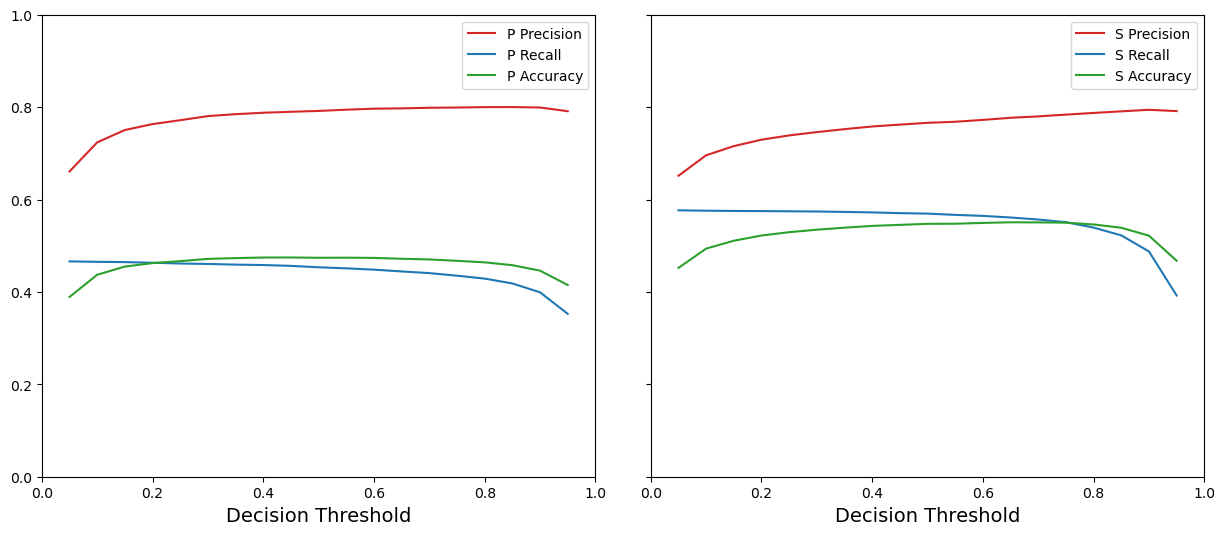

In [12]:
fig = plt.figure()
fig, axs = plt.subplots(
    1, 2,              # 1 row, 2 columns
    figsize=(15, 6),  # overall figure size
    sharey=True,       # share y-axis
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.1}  # control layout
)
axs[0].plot(decision_thresholds, pprecision, label='P Precision', color="tab:red")
axs[0].plot(decision_thresholds, precall, label='P Recall', color="tab:blue")
axs[0].plot(decision_thresholds, paccuracy, label='P Accuracy', color="tab:green")
axs[0].set_xlim(0,1)
axs[0].set_ylim(0,1)
axs[0].legend()

axs[1].plot(decision_thresholds, sprecision, label='S Precision', color="tab:red")
axs[1].plot(decision_thresholds, srecall, label='S Recall', color="tab:blue")
axs[1].plot(decision_thresholds, saccuracy, label='S Accuracy', color="tab:green")
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[0].set_xlabel('Decision Threshold', fontsize=14)
axs[1].set_xlabel('Decision Threshold', fontsize=14)
axs[1].legend()

print("P Precision = "+str(pprecision[9]))
print("P Recall = "+str(precall[9]))
print("P Accuracy = "+str(paccuracy[9]))
print("S Precision = "+str(sprecision[9]))
print("S Recall = "+str(srecall[9]))
print("S Accuracy = "+str(saccuracy[9]))


# 7. Compute and plot the pick distribution

Decision threshold = 0.5
15
1
2


ValueError: The 'color' keyword argument must have one color per dataset, but 2 datasets and 1 colors were provided

<Figure size 640x480 with 0 Axes>

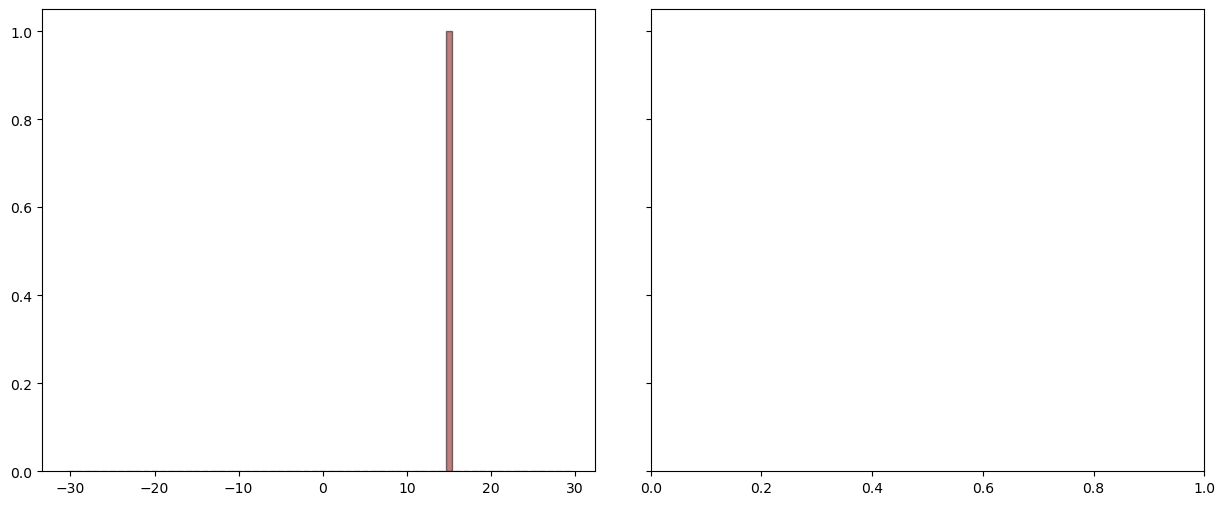

In [13]:
decision_thresholds=[0.5,0.9,0.95]

# Plot the histograms
colors = [[0.5,0,0],[0,0,0.5],[0,0.5,0]]
fig = plt.figure()
fig, axs = plt.subplots(
    1, 2,              # 1 row, 2 columns
    figsize=(15, 6),  # overall figure size
    sharey=True,       # share y-axis
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.1}  # control layout
)

for count, decision_threshold in enumerate(decision_thresholds):
    # Decision threshold
    print("Decision threshold = "+ str(decision_threshold))
    p_pick_diff = []
    s_pick_diff = []
    for ii in range(100,102):
        for jj in range(len(results["p_pred_idx_max"][ii])):
            if results["p_pred_val"][ii][jj] > decision_threshold:
                results.iloc[ii,:]
                print(results["p_pred_idx_max"][ii][jj]-results['p_idx_max'][ii])
                p_pick_diff.append(results["p_pred_idx_max"][ii][jj]-results['p_idx_max'][ii])
        for jj in range(len(results["s_pred_idx_max"][ii])):
            if results["s_pred_val"][ii][jj] > decision_threshold:
                s_pick_diff.append(results["s_pred_idx_max"][ii][jj]-results['s_idx_max'][ii])

    print(len(p_pick_diff))
    print(len(s_pick_diff))

    axs[0].hist(p_pick_diff, bins=np.arange(-30.5,30.5,1), rwidth=0.8, color=colors[count], alpha=0.5, edgecolor='black', label="decision threshold ="+'% 6.2f' % decision_threshold)
    axs[1].hist(s_pick_diff, bins=np.arange(-30.5,30.5,1), rwidth=0.8, color=colors[count], alpha=0.5, edgecolor='black', label="decision threshold ="+'% 6.2f' % decision_threshold)
plt.legend()
axs[0].set_xlabel("Residual [samples]",fontsize=14)
axs[0].set_title("P wave",fontsize=14)
axs[1].set_title("S wave",fontsize=14)
axs[0].set_ylabel("Frequency",fontsize=14)
axs[1].set_xlabel("Residual [samples]",fontsize=14)